## Telco Customer Churn - Part 3 : Model Evaluation for Telco Customer Churn

In [12]:
!pip install -q -r requirements.txt

In [65]:
import imblearn
import sklearn

print(f"imblearn version: {imblearn.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")

imblearn version: 0.14.0
scikit-learn version: 1.7.0


### 0. Imports & helper functions

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (roc_auc_score, average_precision_score, precision_score,
                             recall_score, f1_score, confusion_matrix, precision_recall_curve,
                             roc_curve, auc, classification_report, precision_recall_fscore_support)
import joblib
import os
import warnings
import itertools
from scipy import stats

plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.max_columns', 200)

### 1. Load data and ensure y_test exists (uses X_test, y_test from Part2 if in memory)

In [67]:
if 'X_test' not in globals() or 'y_test' not in globals():
    print("X_test/y_test not in memory - reloading dataset and doing a quick stratified split.")
    df = pd.read_csv('src/data/processed/telco-customer-churn_cleaned.csv')
    df['Churn_flag'] = df['Churn'].map({'No':0,'Yes':1})
    from sklearn.model_selection import train_test_split
    X = df.drop(columns=['Churn','Churn_flag'])
    y = df['Churn_flag']
    X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.2,random_state=42)
else:
    print("Using X_test/y_test available in the notebook namespace.")


Using X_test/y_test available in the notebook namespace.


### 2. Gather models to evaluate.

In [68]:
model_candidates = {
    'LogisticRegression': globals().get('baseline_lr'),        # pipeline
    'DecisionTree': globals().get('baseline_dt'),
    'RandomForest': globals().get('rf_best'),
    'XGBoost': globals().get('xgb_best'),
    'CatBoost': globals().get('cat_best'),
    'Stacking': globals().get('stacking_clf'),
}

# Attempt to load joblib files if needed
joblib_map = {
    'RandomForest': 'models/trained_models/rf_best_pipeline.joblib',
    'DecisionTree': 'models/trained_models/baseline_dt_pipeline.joblib',
    'LogisticRegression': 'models/trained_models/baseline_lr_pipeline.joblib',
    'XGBoost': 'models/trained_models/xgb_best_pipeline.joblib',
    'CatBoost': 'models/trained_models/cat_best_pipeline.joblib',
    'Stacking': 'models/trained_models/stacking_ensemble_pipeline.joblib',
}

for name, path in joblib_map.items():
    if model_candidates.get(name) is None and os.path.exists(path):
        try:
            model_candidates[name] = joblib.load(path)
            print(f'Loaded {name} from {path}')
        except Exception as e:
            print(f'Failed to load {name} from joblib: {e}')

# Filter to models that exist
models = {k:v for k,v in model_candidates.items() if v is not None}
print("Models to evaluate:", list(models.keys()))

Loaded RandomForest from models/trained_models/rf_best_pipeline.joblib
Loaded DecisionTree from models/trained_models/baseline_dt_pipeline.joblib
Loaded LogisticRegression from models/trained_models/baseline_lr_pipeline.joblib
Loaded XGBoost from models/trained_models/xgb_best_pipeline.joblib
Loaded CatBoost from models/trained_models/cat_best_pipeline.joblib
Loaded Stacking from models/trained_models/stacking_ensemble_pipeline.joblib
Models to evaluate: ['LogisticRegression', 'DecisionTree', 'RandomForest', 'XGBoost', 'CatBoost', 'Stacking']
Loaded Stacking from models/trained_models/stacking_ensemble_pipeline.joblib
Models to evaluate: ['LogisticRegression', 'DecisionTree', 'RandomForest', 'XGBoost', 'CatBoost', 'Stacking']


### 3. Utility: safe predict_proba - returns probabilities for positive class

In [69]:
def safe_predict_proba(model, X):
    # Print model information for debugging
    model_type = type(model).__name__
    
    # If the model is a pipeline, try to access the final estimator
    if hasattr(model, 'steps') and len(model.steps) > 0:
        try:
            # Get the final estimator from the pipeline
            final_step_name, final_estimator = model.steps[-1]
            print(f"  Pipeline detected. Final estimator: {type(final_estimator).__name__}")
            
            # First try: use the full pipeline for prediction
            try:
                if hasattr(model, 'predict_proba'):
                    print("  Attempting predict_proba on pipeline...")
                    return model.predict_proba(X)[:, 1]
            except Exception as e:
                print(f"  Pipeline predict_proba failed: {e}")
                
            # Second try: use decision_function on pipeline
            try:
                if hasattr(model, 'decision_function'):
                    print("  Attempting decision_function on pipeline...")
                    scores = model.decision_function(X)
                    # Convert scores to probabilities using sigmoid
                    return 1 / (1 + np.exp(-scores))
            except Exception as e:
                print(f"  Pipeline decision_function failed: {e}")
                
            # Last try: try to apply transformations manually then use final estimator
            print("  Attempting manual pipeline execution...")
            current_data = X
            for step_name, transformer in model.steps[:-1]:
                current_data = transformer.transform(current_data)
            
            if hasattr(final_estimator, 'predict_proba'):
                return final_estimator.predict_proba(current_data)[:, 1]
            elif hasattr(final_estimator, 'decision_function'):
                scores = final_estimator.decision_function(current_data)
                return 1 / (1 + np.exp(-scores))
                
        except Exception as e:
            print(f"  All pipeline approaches failed: {e}")
    
    print(f"  Trying direct model prediction for {model_type}...")
    
    # Try predict_proba
    if hasattr(model, 'predict_proba'):
        try:
            return model.predict_proba(X)[:, 1]
        except Exception as e:
            print(f"  Direct predict_proba failed: {e}")
    
    # Try decision_function
    if hasattr(model, 'decision_function'):
        try:
            scores = model.decision_function(X)
            return 1 / (1 + np.exp(-scores))
        except Exception as e:
            print(f"  Direct decision_function failed: {e}")
    
    # If we reach here, we couldn't get probabilities
    raise ValueError(f"Could not get probability predictions from {model_type} using any method")

In [70]:
# Diagnose loaded models to understand their structure
for name, model in models.items():
    print(f"\n--- Model: {name} ---")
    print(f"Type: {type(model)}")
    
    # Check if it's a pipeline
    if hasattr(model, 'steps'):
        print(f"Pipeline steps: {len(model.steps)}")
        for i, (step_name, step) in enumerate(model.steps):
            print(f"  Step {i}: {step_name} - {type(step)}")
            
        # Check final estimator
        final_step_name, final_estimator = model.steps[-1]
        print(f"\nFinal estimator: {final_step_name} - {type(final_estimator)}")
        print(f"  Has predict_proba: {hasattr(final_estimator, 'predict_proba')}")
        print(f"  Has decision_function: {hasattr(final_estimator, 'decision_function')}")
    else:
        # Not a pipeline
        print(f"Not a pipeline")
        print(f"Has predict_proba: {hasattr(model, 'predict_proba')}")
        print(f"Has decision_function: {hasattr(model, 'decision_function')}")


--- Model: LogisticRegression ---
Type: <class 'sklearn.pipeline.Pipeline'>
Pipeline steps: 2
  Step 0: pre - <class 'sklearn.compose._column_transformer.ColumnTransformer'>
  Step 1: clf - <class 'sklearn.linear_model._logistic.LogisticRegression'>

Final estimator: clf - <class 'sklearn.linear_model._logistic.LogisticRegression'>
  Has predict_proba: True
  Has decision_function: True

--- Model: DecisionTree ---
Type: <class 'sklearn.pipeline.Pipeline'>
Pipeline steps: 2
  Step 0: pre - <class 'sklearn.compose._column_transformer.ColumnTransformer'>
  Step 1: clf - <class 'sklearn.tree._classes.DecisionTreeClassifier'>

Final estimator: clf - <class 'sklearn.tree._classes.DecisionTreeClassifier'>
  Has predict_proba: True
  Has decision_function: False

--- Model: RandomForest ---
Type: <class 'sklearn.pipeline.Pipeline'>
Pipeline steps: 2
  Step 0: pre - <class 'sklearn.compose._column_transformer.ColumnTransformer'>
  Step 1: clf - <class 'sklearn.ensemble._forest.RandomForestCla

In [71]:
# Detailed inspection of stacking model structure
if 'Stacking' in models and isinstance(models['Stacking'], dict):
    stacking_model = models['Stacking']
    print("\n=== Stacking Model Detailed Inspection ===")
    print(f"Dictionary keys: {list(stacking_model.keys())}")
    
    # Check for common stacking model structures
    if 'meta_estimator' in stacking_model:
        print(f"\nMeta-estimator type: {type(stacking_model['meta_estimator'])}")
        print(f"Meta-estimator has predict_proba: {hasattr(stacking_model['meta_estimator'], 'predict_proba')}")
    
    if 'base_models' in stacking_model:
        print("\nBase models:")
        for name, model in stacking_model['base_models'].items():
            print(f"  - {name}: {type(model)}")
            print(f"    Has predict_proba: {hasattr(model, 'predict_proba')}")
    
    # For StackingClassifier-like structure
    if 'estimators_' in stacking_model:
        print("\nFound sklearn StackingClassifier-like structure")
        print(f"estimators_: {stacking_model['estimators_']}")
        
    if 'final_estimator_' in stacking_model:
        print(f"\nfinal_estimator_: {type(stacking_model['final_estimator_'])}")
    
    # Other possible attributes
    for key in ['stack_method', 'passthrough', 'classes_']:
        if key in stacking_model:
            print(f"\n{key}: {stacking_model[key]}")


=== Stacking Model Detailed Inspection ===
Dictionary keys: ['preprocessor', 'model']


### 4. Evaluate each model at default threshold 0.5, and compute PR/ROC AUC

In [72]:
results = {}
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    
    try:
        # Special handling for stacking model if it's a dictionary
        if isinstance(model, dict) and name == 'Stacking':
            print("  Detected stacking model as dictionary, using custom prediction logic")
            # This assumes the stacking model dictionary contains base models and meta-estimator
            if 'meta_estimator' in model and 'base_models' in model:
                # First get base model predictions
                base_preds = []
                for base_name, base_model in model['base_models'].items():
                    try:
                        base_pred = safe_predict_proba(base_model, X_test)
                        base_preds.append(base_pred)
                    except Exception as e:
                        print(f"  Base model {base_name} failed: {e}")
                
                if base_preds:
                    # Convert base predictions to array for meta-estimator
                    meta_features = np.column_stack(base_preds)
                    # Get final predictions using meta-estimator
                    try:
                        meta_estimator = model['meta_estimator']
                        probs = safe_predict_proba(meta_estimator, meta_features)
                    except Exception as e:
                        print(f"  Meta-estimator failed: {e}")
                        continue
                else:
                    print("  No base models produced valid predictions")
                    continue
            else:
                print("  Stacking model dictionary doesn't have expected structure")
                continue
        else:
            # Normal case for standard models
            probs = safe_predict_proba(model, X_test)
        
        # Continue with evaluation using the probabilities
        preds = (probs >= 0.5).astype(int)
        roc = roc_auc_score(y_test, probs)
        pr = average_precision_score(y_test, probs)
        prec = precision_score(y_test, preds)
        rec = recall_score(y_test, preds)
        f1 = f1_score(y_test, preds)
        cm = confusion_matrix(y_test, preds)
        results[name] = {
            'roc_auc': roc, 'pr_auc': pr, 'precision': prec, 'recall': rec, 'f1': f1, 'confusion_matrix': cm,
            'probs': probs
        }
        print(f"  Successfully evaluated {name}! ROC AUC: {roc:.4f}, F1: {f1:.4f}")
    except Exception as e:
        print(f"  Skipping {name} - cannot get probabilities: {e}")
        continue

# Show summary table
if results:  # Check if any models were successfully evaluated
    summary = pd.DataFrame({k:{'roc_auc':v['roc_auc'],'pr_auc':v['pr_auc'],'precision':v['precision'],'recall':v['recall'],'f1':v['f1']} for k,v in results.items()}).T
    display(summary.sort_values('roc_auc', ascending=False))
else:
    print("No models were successfully evaluated. Check that your models have predict_proba or decision_function methods.")

# Detailed error handling for troubleshooting
if not results:
    print("\nTroubleshooting tips:")
    print("1. Ensure the X_test data has all required columns with correct datatypes")
    print("2. Check that the models were saved and loaded correctly")
    print("3. Review the preprocessing in the previous notebook")
    print("\nX_test columns:")
    print(X_test.columns.tolist())


Evaluating LogisticRegression...
  Pipeline detected. Final estimator: LogisticRegression
  Attempting predict_proba on pipeline...
  Successfully evaluated LogisticRegression! ROC AUC: 0.6873, F1: 0.4881

Evaluating DecisionTree...
  Pipeline detected. Final estimator: DecisionTreeClassifier
  Attempting predict_proba on pipeline...
  Successfully evaluated DecisionTree! ROC AUC: 0.6087, F1: 0.4297

Evaluating RandomForest...
  Pipeline detected. Final estimator: RandomForestClassifier
  Attempting predict_proba on pipeline...
  Successfully evaluated RandomForest! ROC AUC: 0.8373, F1: 0.6282

Evaluating XGBoost...
  Pipeline detected. Final estimator: XGBClassifier
  Attempting predict_proba on pipeline...
  Successfully evaluated XGBoost! ROC AUC: 0.8458, F1: 0.5710

Evaluating CatBoost...
  Pipeline detected. Final estimator: CatBoostClassifier
  Attempting predict_proba on pipeline...
  Pipeline predict_proba failed: Invalid type for cat_feature[non-default value idx=0,feature_id

,roc_auc,pr_auc,precision,recall,f1
XGBoost,0.845833,0.658322,0.685393,0.489305,0.570983
RandomForest,0.837277,0.651116,0.552846,0.727273,0.628176
LogisticRegression,0.687259,0.421364,0.327539,0.957219,0.488071
DecisionTree,0.608743,0.331811,0.411765,0.449198,0.429668


In [73]:
# Create the missing engineered features that the models expect
print("Creating missing engineered features...")

# 1. tenure_category
if 'tenure' in X_test.columns and 'tenure_category' not in X_test.columns:
    # Create tenure category based on common ranges
    bins = [0, 12, 24, 36, 60, float('inf')]
    labels = ['0-12 mo', '13-24 mo', '25-36 mo', '37-60 mo', '60+ mo']
    X_test['tenure_category'] = pd.cut(X_test['tenure'], bins=bins, labels=labels, right=False)
    print("  Created 'tenure_category'")

# 2. contract_tenure_interaction
if 'Contract' in X_test.columns and 'tenure' in X_test.columns and 'contract_tenure_interaction' not in X_test.columns:
    # Create interaction feature between contract type and tenure
    contract_map = {'Month-to-month': 1, 'One year': 12, 'Two year': 24}
    X_test['contract_months'] = X_test['Contract'].map(contract_map)
    X_test['contract_tenure_interaction'] = X_test['tenure'] / X_test['contract_months']
    # Remove temporary column
    X_test = X_test.drop(columns=['contract_months'])
    print("  Created 'contract_tenure_interaction'")

# 3. service_adoption_score
if 'service_adoption_score' not in X_test.columns:
    # Create service adoption score - count of services the customer has
    service_columns = [
        'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
        'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
    ]
    # Ensure all service columns exist
    available_service_columns = [col for col in service_columns if col in X_test.columns]
    
    # Convert 'Yes' to 1 for services
    service_data = X_test[available_service_columns].copy()
    for col in available_service_columns:
        if X_test[col].dtype == 'object':
            # Convert 'Yes' to 1, 'No' to 0, exclude 'No phone service'/'No internet service'
            service_data[col] = (X_test[col] == 'Yes').astype(int)
    
    # Sum across rows to get service count
    X_test['service_adoption_score'] = service_data.sum(axis=1)
    print(f"  Created 'service_adoption_score' using {len(available_service_columns)} service columns")

# 4. avg_charge_per_service
if 'MonthlyCharges' in X_test.columns and 'service_adoption_score' in X_test.columns and 'avg_charge_per_service' not in X_test.columns:
    # Calculate average charge per service
    X_test['avg_charge_per_service'] = X_test['MonthlyCharges'] / (X_test['service_adoption_score'] + 1)  # Add 1 to avoid division by zero
    print("  Created 'avg_charge_per_service'")

print("Feature engineering complete.")

Creating missing engineered features...
Feature engineering complete.


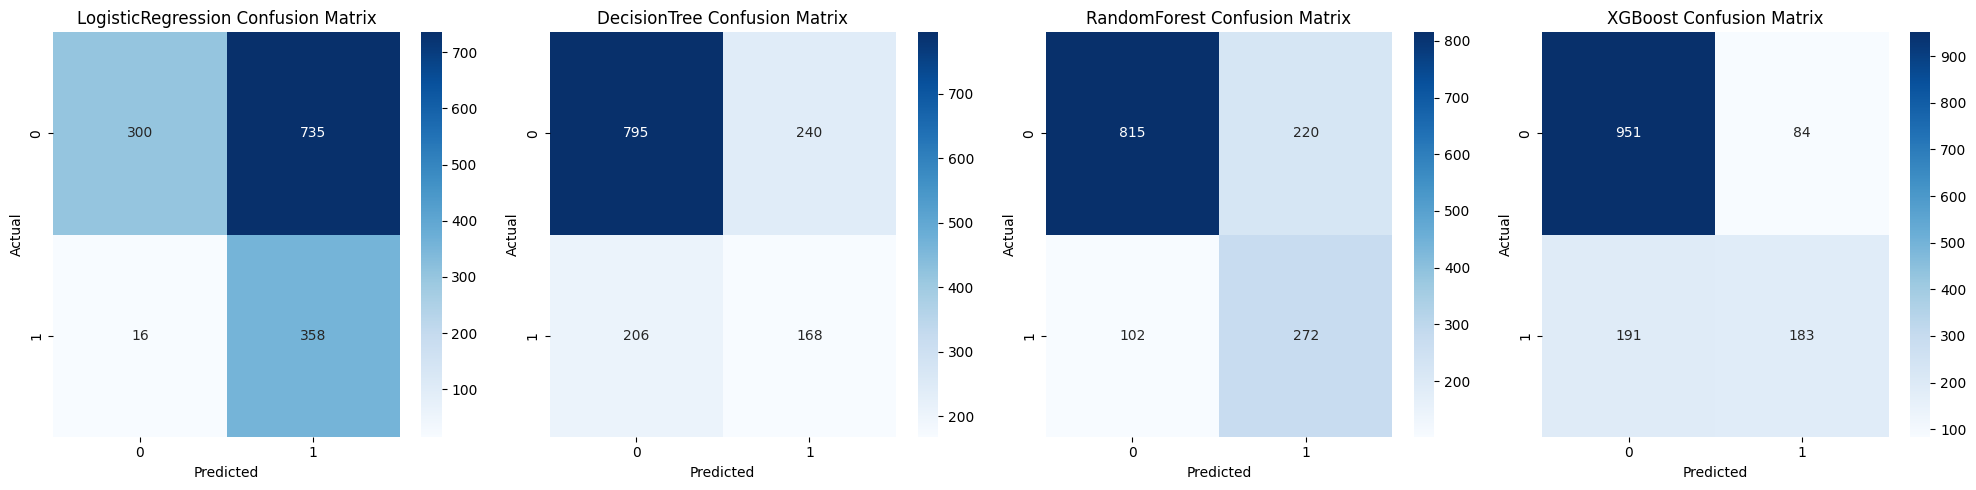

In [ ]:
    # Plot confusion matrices
    n_models = len(results)
    fig, axes = plt.subplots(1, n_models, figsize=(n_models*5, 5))
    if n_models == 1:
        axes = [axes]
        
    for i, (name, res) in enumerate(results.items()):
        cm = res['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'{name} Confusion Matrix')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()


#### 3.1 Why Accuracy Fails (demonstration)
- example: if churn is ~26% (as earlier), a dumb model predicting "No churn" always has high accuracy.


In [75]:
# accuracy vs other metrics demo

majority_pred = np.zeros_like(y_test)  # predict No (0) always
acc = accuracy_score(y_test, majority_pred)
prec = precision_score(y_test, majority_pred, zero_division=0)
rec = recall_score(y_test, majority_pred)
f1 = f1_score(y_test, majority_pred)

print(f"Majority classifier -> accuracy: {acc:.3f}, precision: {prec:.3f}, recall: {rec:.3f}, f1: {f1:.3f}")
print("Conclusion: Accuracy is high but recall = 0 (misses all churners).")


Majority classifier -> accuracy: 0.735, precision: 0.000, recall: 0.000, f1: 0.000
Conclusion: Accuracy is high but recall = 0 (misses all churners).


#### 3.2 Threshold Sweep, Precision-Recall & ROC curves
- Compute ROC curve and PR curve for each model and plot


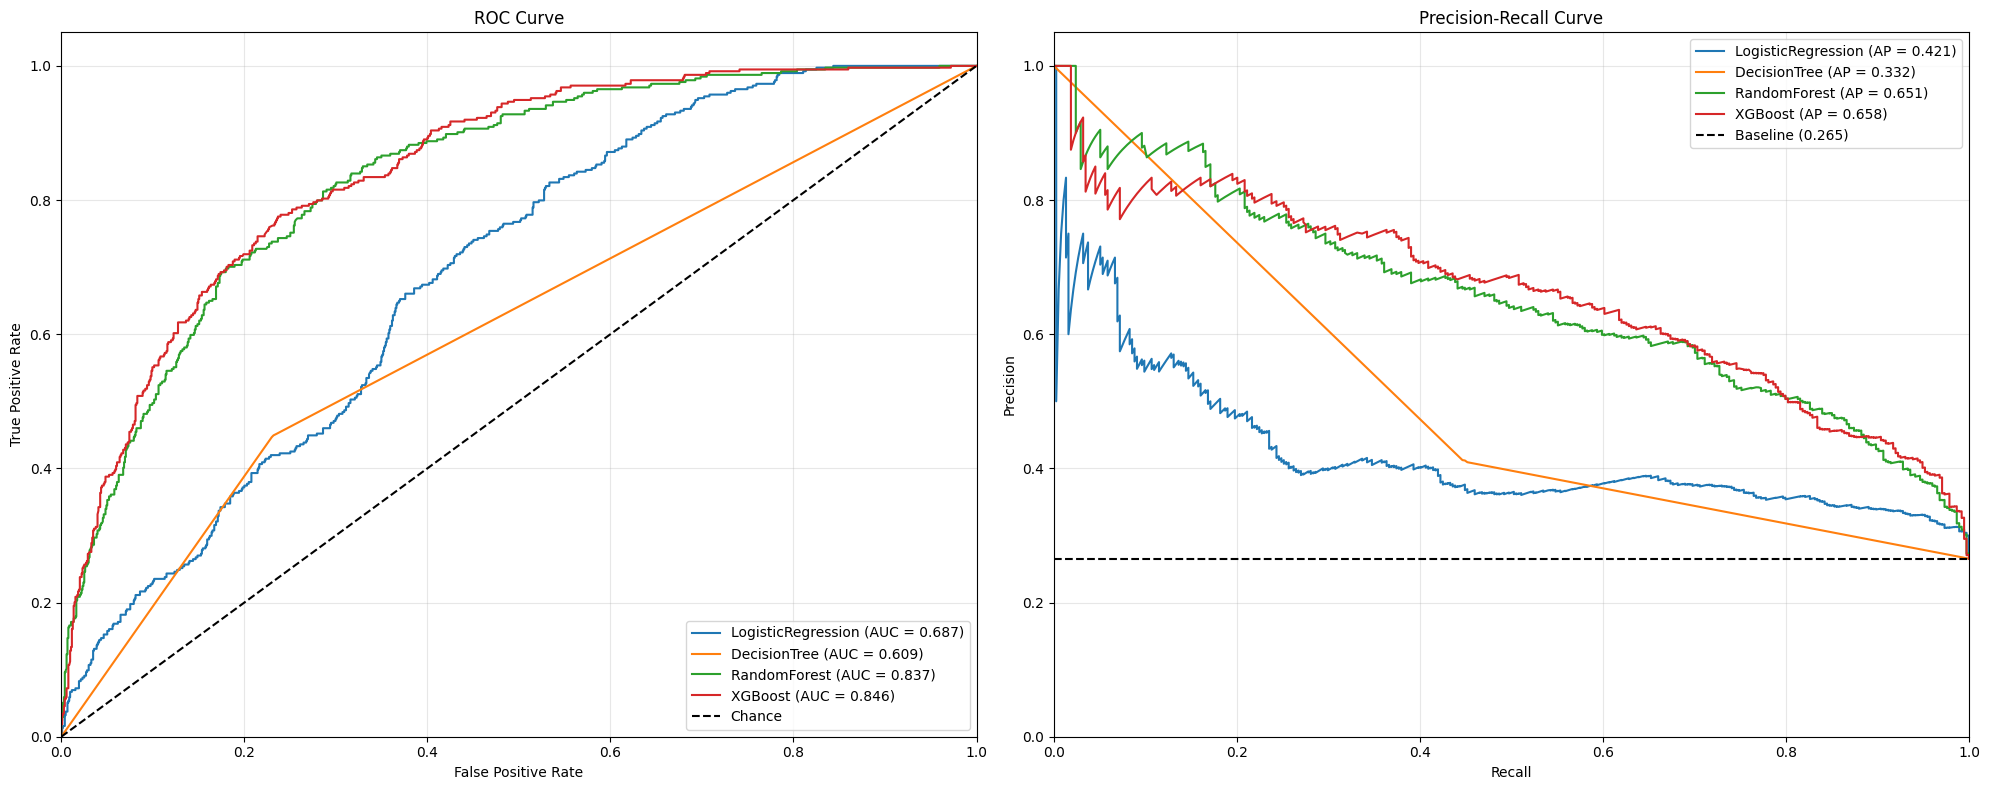

In [79]:
if results:
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # ROC Curve
    for name, res in results.items():
        fpr, tpr, _ = roc_curve(y_test, res['probs'])
        axes[0].plot(fpr, tpr, label=f"{name} (AUC = {res['roc_auc']:.3f})")
    
    # Add chance line
    axes[0].plot([0, 1], [0, 1], 'k--', label='Chance')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve')
    axes[0].legend(loc="lower right")
    axes[0].grid(True, alpha=0.3)
    
    # PR Curve
    for name, res in results.items():
        precision, recall, _ = precision_recall_curve(y_test, res['probs'])
        axes[1].plot(recall, precision, label=f"{name} (AP = {res['pr_auc']:.3f})")
    
    # Add baseline
    baseline = sum(y_test) / len(y_test)  # Proportion of positives
    axes[1].plot([0, 1], [baseline, baseline], 'k--', label=f'Baseline ({baseline:.3f})')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('Precision-Recall Curve')
    axes[1].legend(loc="upper right")
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

##### 3.2.1 Threshold optimization examples:
- maximize F1
- choose threshold to ensure minimum precision (e.g., >= 0.5)

In [81]:
thresh_summary = {}

for name, r in results.items():
    precision, recall, thresholds = precision_recall_curve(y_test, r['probs'])
    # thresholds.shape == (len(precision)-1,)
    # precision[1:], recall[1:] correspond to thresholds
    prec_at_thresh = precision[1:]
    rec_at_thresh = recall[1:]
    
    # compute F1 at the thresholds
    f1_at_thresh = 2 * prec_at_thresh * rec_at_thresh / (prec_at_thresh + rec_at_thresh + 1e-9)
    
    if len(f1_at_thresh) > 0:
        best_idx = np.nanargmax(f1_at_thresh)
        best_thresh = thresholds[best_idx]
        best_f1 = f1_at_thresh[best_idx]
    else:
        # fallback
        best_thresh = 0.5
        best_f1 = np.nan
    
    # find threshold with precision >= 0.50 (largest recall among them)
    idxs = np.where(prec_at_thresh >= 0.50)[0]
    if len(idxs) > 0:
        idx = idxs[-1]  # last index gives largest recall while precision >= 0.5
        thr_prec50 = thresholds[idx]
        prec50_recall = rec_at_thresh[idx]
    else:
        thr_prec50 = None
        prec50_recall = None

    # compute actual metrics at chosen thresholds
    y_pred_best_f1 = (r['probs'] >= best_thresh).astype(int)
    p_f1, r_f1, f1_f1, _ = precision_recall_fscore_support(y_test, y_pred_best_f1, average='binary', zero_division=0)

    if thr_prec50 is not None:
        y_pred_prec50 = (r['probs'] >= thr_prec50).astype(int)
        p_50, r_50, f1_50, _ = precision_recall_fscore_support(y_test, y_pred_prec50, average='binary', zero_division=0)
    else:
        p_50 = r_50 = f1_50 = None

    thresh_summary[name] = {
        'best_f1': best_f1,
        'best_thresh': best_thresh,
        'best_f1_precision': p_f1,
        'best_f1_recall': r_f1,
        'thr_prec50': thr_prec50,
        'prec50_recall': prec50_recall,
        'prec50_precision': p_50,
        'prec50_recall_metric': r_50,
        'prec50_f1_metric': f1_50
    }

pd.DataFrame(thresh_summary).T

,best_f1,best_thresh,best_f1_precision,best_f1_recall,thr_prec50,prec50_recall,prec50_precision,prec50_recall_metric,prec50_f1_metric
LogisticRegression,0.500405,0.790423,0.358469,0.826203,0.999272,0.0,1.000000,0.002674,0.005333
DecisionTree,0.429668,0.479940,0.409201,0.451872,1.000000,0.0,0.412346,0.446524,0.428755
RandomForest,0.636364,0.537434,0.587302,0.692513,0.816787,0.0,1.000000,0.002674,0.005333
XGBoost,0.638064,0.289317,0.541045,0.775401,0.894076,0.0,1.000000,0.002674,0.005333


##### full classification reports + confusion matrices:

In [83]:
rows = []

# thresh_summary is the dict created earlier containing 'best_thresh' and 'thr_prec50' for each model
for name, s in thresh_summary.items():
    probs = results[name]['probs']
    for thr_label in ['best_thresh', 'thr_prec50']:
        thr = s.get(thr_label)
        if thr is None:
            # skip if no threshold found for the criterion
            rows.append({
                'model': name,
                'threshold_label': thr_label,
                'threshold': None,
                'TP': None, 'FP': None, 'FN': None, 'TN': None,
                'precision': None, 'recall': None, 'f1': None, 'support_pos': None
            })
            continue

        y_pred = (probs >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        p, r, f1, sup = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
        # store
        rows.append({
            'model': name,
            'threshold_label': thr_label,
            'threshold': thr,
            'TP': int(tp), 'FP': int(fp), 'FN': int(fn), 'TN': int(tn),
            'precision': float(p), 'recall': float(r), 'f1': float(f1), 
            'support_pos': sum(y_test) if sup is None else int(sup)  # Fix: handle None value for support
        })

summary_df = pd.DataFrame(rows)
# better ordering
summary_df = summary_df[['model','threshold_label','threshold','TP','FP','FN','TN','precision','recall','f1','support_pos']]
display(summary_df.sort_values(['model','threshold_label']))

for idx, r in summary_df.iterrows():
    if pd.isna(r['threshold']):
        print(f"\n{name} - {r['threshold_label']}: no threshold available\n")
        continue
    name = r['model']
    thr = r['threshold']
    y_pred = (results[name]['probs'] >= thr).astype(int)
    print(f"\n=== {name} @ {r['threshold_label']} = {thr:.4f} ===")
    print("Confusion matrix (tn, fp, fn, tp):", confusion_matrix(y_test, y_pred).ravel())
    print(classification_report(y_test, y_pred, zero_division=0))

,model,threshold_label,threshold,TP,FP,FN,TN,precision,recall,f1,support_pos
2,DecisionTree,best_thresh,0.479940,169,244,205,791,0.409201,0.451872,0.429479,374
3,DecisionTree,thr_prec50,1.000000,167,238,207,797,0.412346,0.446524,0.428755,374
0,LogisticRegression,best_thresh,0.790423,309,553,65,482,0.358469,0.826203,0.500000,374
1,LogisticRegression,thr_prec50,0.999272,1,0,373,1035,1.000000,0.002674,0.005333,374
4,RandomForest,best_thresh,0.537434,259,182,115,853,0.587302,0.692513,0.635583,374
5,RandomForest,thr_prec50,0.816787,1,0,373,1035,1.000000,0.002674,0.005333,374
6,XGBoost,best_thresh,0.289317,290,246,84,789,0.541045,0.775401,0.637363,374
7,XGBoost,thr_prec50,0.894076,1,0,373,1035,1.000000,0.002674,0.005333,374



=== LogisticRegression @ best_thresh = 0.7904 ===
Confusion matrix (tn, fp, fn, tp): [482 553  65 309]
              precision    recall  f1-score   support

           0       0.88      0.47      0.61      1035
           1       0.36      0.83      0.50       374

    accuracy                           0.56      1409
   macro avg       0.62      0.65      0.55      1409
weighted avg       0.74      0.56      0.58      1409


=== LogisticRegression @ thr_prec50 = 0.9993 ===
Confusion matrix (tn, fp, fn, tp): [1035    0  373    1]
              precision    recall  f1-score   support

           0       0.74      1.00      0.85      1035
           1       1.00      0.00      0.01       374

    accuracy                           0.74      1409
   macro avg       0.87      0.50      0.43      1409
weighted avg       0.81      0.74      0.62      1409


=== DecisionTree @ best_thresh = 0.4799 ===
Confusion matrix (tn, fp, fn, tp): [791 244 205 169]
              precision    recall  f1

### 3.2.2 Cost-Sensitive Analysis (business-focused)
define a simple cost model:
 - cost_fp: cost of contacting a non-churner (marketing cost per contact) -> default = $10
 - cost_fn: cost of letting a churner go (lost customer value).

In [84]:
cost_fp = 10.0             
months_lost = 6            

# approximate loss per lost customer = avg MonthlyCharges * months_lost
avg_monthly = X_test.join(y_test).iloc[:,0:].pipe(lambda d: d) 
# compute avg MonthlyCharges from original dataset
try:
    avg_monthly_charge = float(df['MonthlyCharges'].mean())
except Exception:
    avg_monthly_charge = 70.0
cost_fn = avg_monthly_charge * months_lost

print(f"Assumed cost_fp=${cost_fp:.2f}, cost_fn=${cost_fn:.2f} ({months_lost} months avg revenue)")

Assumed cost_fp=$10.00, cost_fn=$388.57 (6 months avg revenue)


In [85]:
# function to compute expected cost for a model at a threshold
def compute_business_cost(y_true, probs, threshold=0.5, cost_fp=10.0, cost_fn=420.0):
    preds = (probs >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
    total_cost = fp * cost_fp + fn * cost_fn
    return {'tn':tn,'fp':fp,'fn':fn,'tp':tp,'total_cost':total_cost}

# baseline cost if we do nothing: treat all churners as missed (i.e., FN = total churners)
no_action_cost = (y_test==1).sum() * cost_fn
print("No-action cost (miss all churners):", no_action_cost)

No-action cost (miss all churners): 145325.23788158456


In [86]:
# compute business cost across thresholds and find optimal threshold that minimizes cost for each model
cost_opt = {}
th_grid = np.linspace(0.01,0.99,99)
for name, r in results.items():
    costs = []
    for th in th_grid:
        c = compute_business_cost(y_test, r['probs'], threshold=th, cost_fp=cost_fp, cost_fn=cost_fn)
        costs.append(c['total_cost'])
    costs = np.array(costs)
    min_idx = costs.argmin()
    cost_opt[name] = {'min_cost': costs[min_idx], 'best_threshold': th_grid[min_idx], 'savings_vs_no_action': no_action_cost - costs[min_idx]}
    
pd.DataFrame(cost_opt).T.sort_values('min_cost')

,min_cost,best_threshold,savings_vs_no_action
XGBoost,8447.140310,0.04,136878.097572
LogisticRegression,8760.000000,0.17,136565.237882
RandomForest,9078.570155,0.16,136246.667727
DecisionTree,82096.881727,0.01,63228.356155


### 3.3 Model Comparison Framework: table + statistical tests
- Build final performance matrix (use ROC AUC, PR AUC, precision, recall, f1)
- Statistical tests: McNemar for paired classification differences at a selected threshold
- Bootstrap for difference in ROC AUC


#### 3.3.1 Performance matrix (includes optimal-threshold-based metrics)

In [88]:
perf_rows = []
for name, r in results.items():
    # default threshold metrics
    probs = r['probs']
    default_preds = (probs >= 0.5).astype(int)
    cm = confusion_matrix(y_test, default_preds)
    row = {
        'model': name,
        'roc_auc': r['roc_auc'],
        'pr_auc': r['pr_auc'],
        'precision(0.5)': precision_score(y_test, default_preds, zero_division=0),
        'recall(0.5)': recall_score(y_test, default_preds),
        'f1(0.5)': f1_score(y_test, default_preds),
    }
    # add cost-optimized threshold metrics
    best_th = cost_opt[name]['best_threshold']
    best_preds = (probs >= best_th).astype(int)
    row.update({
        'best_thresh': best_th,
        'precision(best)': precision_score(y_test, best_preds, zero_division=0),
        'recall(best)': recall_score(y_test, best_preds),
        'f1(best)': f1_score(y_test, best_preds),
        'min_cost': cost_opt[name]['min_cost'],
        'savings_vs_no_action': cost_opt[name]['savings_vs_no_action']
    })
    perf_rows.append(row)

perf_df = pd.DataFrame(perf_rows).set_index('model').sort_values('roc_auc', ascending=False)
display(perf_df)

,roc_auc,pr_auc,precision(0.5),recall(0.5),f1(0.5),best_thresh,precision(best),recall(best),f1(best),min_cost,savings_vs_no_action
model,,,,,,,,,,,
XGBoost,0.845833,0.658322,0.685393,0.489305,0.570983,0.04,0.326602,0.994652,0.491738,8447.140310,136878.097572
RandomForest,0.837277,0.651116,0.552846,0.727273,0.628176,0.16,0.300322,0.997326,0.461634,9078.570155,136246.667727
LogisticRegression,0.687259,0.421364,0.327539,0.957219,0.488071,0.17,0.299200,1.000000,0.460591,8760.000000,136565.237882
DecisionTree,0.608743,0.331811,0.411765,0.449198,0.429668,0.01,0.409201,0.451872,0.429479,82096.881727,63228.356155


#### 3.3.2 McNemar's test for pairwise model comparisons (at chosen threshold)

In [91]:
def mcnemar_test(y_true, pred_a, pred_b):
    # b = pred_a==1 & pred_b==0
    # c = pred_a==0 & pred_b==1
    b = np.sum((pred_a==1) & (pred_b==0) & (y_true==1))
    c = np.sum((pred_a==0) & (pred_b==1) & (y_true==1))
    # continuity correction
    stat = (abs(b - c) - 1)**2 / (b + c + 1e-9)
    pvalue = 1 - stats.chi2.cdf(stat, df=1)
    return {'b':b, 'c':c, 'stat':stat, 'pvalue':pvalue}

# run pairwise for top 3 models by ROC AUC
top_models = perf_df.index.tolist()[:3]
mcnemar_results = {}
for a,b in itertools.combinations(top_models,2):
    probs_a = results[a]['probs']; probs_b = results[b]['probs']
    # use cost-optimized thresholds for fairness
    pa = (probs_a >= cost_opt[a]['best_threshold']).astype(int)
    pb = (probs_b >= cost_opt[b]['best_threshold']).astype(int)
    res = mcnemar_test(y_test.values, pa, pb)
    mcnemar_results[f'{a} vs {b}'] = res

pd.DataFrame(mcnemar_results).T

,b,c,stat,pvalue
XGBoost vs RandomForest,1.0,2.0,0.0,1.0000
XGBoost vs LogisticRegression,0.0,2.0,0.5,0.4795
RandomForest vs LogisticRegression,0.0,1.0,0.0,1.0000


#### 3.3.3 Bootstrap test for ROC AUC difference between two models

In [92]:
def bootstrap_auc_diff(y_true, probs_a, probs_b, n_bootstraps=1000, seed=42):
    rng = np.random.RandomState(seed)
    n = len(y_true)
    diffs = []
    for i in range(n_bootstraps):
        idx = rng.randint(0, n, n)
        try:
            auc_a = roc_auc_score(y_true[idx], probs_a[idx])
            auc_b = roc_auc_score(y_true[idx], probs_b[idx])
            diffs.append(auc_a - auc_b)
        except ValueError:
            # skip iterations where a class is missing in the sample
            continue
    diffs = np.array(diffs)
    mean_diff = diffs.mean()
    ci_low = np.percentile(diffs, 2.5)
    ci_high = np.percentile(diffs, 97.5)
    p_val = 2 * min((diffs > 0).mean(), (diffs < 0).mean())  # two-sided
    return {'mean_diff': mean_diff, 'ci':(ci_low,ci_high), 'pvalue':p_val}

# compare best two models
if len(top_models) >= 2:
    a,b = top_models[0], top_models[1]
    res_boot = bootstrap_auc_diff(y_test.values, results[a]['probs'], results[b]['probs'], n_bootstraps=1000)
    print(f"Bootstrap AUC diff ({a} - {b}):", res_boot)

Bootstrap AUC diff (XGBoost - RandomForest): {'mean_diff': 0.008352329152429894, 'ci': (0.0018013143175206333, 0.014552498073162497), 'pvalue': 0.016}


### 5. Models Performance Summary

In [93]:
# Create a more detailed performance table
print("=== Model Performance Summary ===")
    
# Get best model for each metric
best_roc = max(results.items(), key=lambda x: x[1]['roc_auc'])
best_pr = max(results.items(), key=lambda x: x[1]['pr_auc'])
best_f1 = max(results.items(), key=lambda x: x[1]['f1'])
best_precision = max(results.items(), key=lambda x: x[1]['precision'])
best_recall = max(results.items(), key=lambda x: x[1]['recall'])

print(f"\nBest ROC AUC: {best_roc[0]} with {best_roc[1]['roc_auc']:.4f}")
print(f"Best PR AUC: {best_pr[0]} with {best_pr[1]['pr_auc']:.4f}")
print(f"Best F1 Score: {best_f1[0]} with {best_f1[1]['f1']:.4f}")
print(f"Best Precision: {best_precision[0]} with {best_precision[1]['precision']:.4f}")
print(f"Best Recall: {best_recall[0]} with {best_recall[1]['recall']:.4f}")
    
# Print detailed interpretation
print("\n=== Model Interpretation ===")
print("ROC AUC - Higher values indicate better ability to distinguish between churners and non-churners")
print("PR AUC - Higher values indicate better precision-recall trade-off, important for imbalanced classes")
print("F1 Score - Harmonic mean of precision and recall, good when both metrics are important")
print("Precision - Proportion of true positive predictions among all positive predictions")
print("Recall - Proportion of true positive predictions among all actual positives (churners)")

=== Model Performance Summary ===

Best ROC AUC: XGBoost with 0.8458
Best PR AUC: XGBoost with 0.6583
Best F1 Score: RandomForest with 0.6282
Best Precision: XGBoost with 0.6854
Best Recall: LogisticRegression with 0.9572

=== Model Interpretation ===
ROC AUC - Higher values indicate better ability to distinguish between churners and non-churners
PR AUC - Higher values indicate better precision-recall trade-off, important for imbalanced classes
F1 Score - Harmonic mean of precision and recall, good when both metrics are important
Precision - Proportion of true positive predictions among all positive predictions
Recall - Proportion of true positive predictions among all actual positives (churners)


### 6. Save results & Final recommendations
- Save perf_df and threshold decisions to csv for reporting


In [98]:
pd.DataFrame(perf_df)

,roc_auc,pr_auc,precision(0.5),recall(0.5),f1(0.5),best_thresh,precision(best),recall(best),f1(best),min_cost,savings_vs_no_action
model,,,,,,,,,,,
XGBoost,0.845833,0.658322,0.685393,0.489305,0.570983,0.04,0.326602,0.994652,0.491738,8447.140310,136878.097572
RandomForest,0.837277,0.651116,0.552846,0.727273,0.628176,0.16,0.300322,0.997326,0.461634,9078.570155,136246.667727
LogisticRegression,0.687259,0.421364,0.327539,0.957219,0.488071,0.17,0.299200,1.000000,0.460591,8760.000000,136565.237882
DecisionTree,0.608743,0.331811,0.411765,0.449198,0.429668,0.01,0.409201,0.451872,0.429479,82096.881727,63228.356155


In [96]:
perf_df.to_csv('src/data/external/models_performance_summary.csv')
print("Saved performance summary to src/data/external/models_performance_summary.csv")

Saved performance summary to src/data/external/models_performance_summary.csv
